# Figure 6: Individual state entropies for the 3 mosquito model

## Abby Barlow, Univeristy of Bath
## Ben Adams, University of Bath

Importing required libraries

In [1]:
import numpy as np
import itertools
from scipy.linalg import expm
import pylab as plt
import matplotlib
import sympy as sp

Importing required scripts

In [2]:
import importlib
import Rate_transitions
import Finding_sub_Q
import Lower_block_triangular
import Finding_full_Q
import Entropies
import Hughes_model

get_transition = Rate_transitions.get_transition_Hughes
getQk = Finding_sub_Q.getQk_Hughes
LBTQ = Lower_block_triangular.LBTQ_Hughes_comp
getQ = Finding_full_Q.getQ_Hughes
entropy = Entropies.entropy
F = Hughes_model.F_hughes

# scripts autosave, so no need to re-run code chunk after making changes
%load_ext autoreload
%autoreload 2

Parameter values

In [3]:
# set some parameter values 

K = 3            # reproductive carrying capacity
k = 0.3          # Mosquito competition parameter
h = 0.19*100**k  # Mosquito competition parameter
d1 = 12/100      # wild-type death rate
d2 = 12/100      # Wolbachia death rate
xstar = 2        # imposed steady state (for wild type population)
b1 = round(d1/F(xstar,h,k,K),2) # wild-type per capita birth rate
phi = 85/100       # Wolbachia fitness
b2 = b1*phi      # Wolbachia  per capita fitness
v = 10/10        # probability of vertical transmission
u = 10/10        # probability of viable offspring


# create a dictionary to store all parameter values
params_dict = {'b1': b1,
              'b2': b2,
              'K': K,
              'h': h,
              'k': k,
              'd1': d1,
              'd2': d2,
              'v': v,
              'u': u,
              'phi': phi}

Construct a dictionary of all the state variables

In [4]:
# construct a dictionary that associated an integer index with each possible states, states are stored as an np.array - easier to apply mathematical operations than tuple 
max_pop = 3 # maximum household size
state_dict = {index: np.array((i, j)) for index, (i, j) in enumerate([(i, j) for i in range(max_pop + 1) for j in range(max_pop + 1) if i + j <= max_pop])}

Construct the full transition matrix

In [5]:
# construct a matrix Q for the transition rate q_ij betweeen states i and j
n_states = len(state_dict)  # total number of states

Q = getQ(state_dict,params_dict)
print(Q)

[[-0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.12       -0.2396846   0.1196846   0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.24       -0.44097261  0.20097261  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.36       -0.36        0.          0.
   0.          0.          0.          0.        ]
 [ 0.12        0.          0.          0.         -0.26080541  0.
   0.          0.14080541  0.          0.        ]
 [ 0.          0.12        0.          0.          0.12       -0.3995959
   0.1004863   0.          0.05910959  0.        ]
 [ 0.          0.          0.12        0.          0.          0.24
  -0.36        0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.24        0.
   0.         -0.47643836  0.          0.23643836]
 [ 0.          0.          0.          0.          0.  

Constructing individual dictionaries of the communicating state classes and their respective sub-Q matrices

In [6]:
### S1 corresponds to the wild-type-only states, S2 to the Wolbachia-only and S3 the mixed states
state_dict_S1 = {index: np.array((i, 0)) for index, i in enumerate([i for i in range(1,max_pop + 1)])}
state_dict_S2 = {index: np.array((0, i)) for index, i in enumerate([i for i in range(1,max_pop + 1)])}
state_dict_S3 = {index: np.array((i,j)) for index, (i,j) in enumerate([(i, j) for i in range(1,max_pop + 1) for j in range(1,max_pop + 1) if i + j <= max_pop])}

# finding the sub-q matrices and their respective ordered lists of states in the class
# we will use these list to rearrange Q into lower block triangular form
Q1,key_list1 = getQk(state_dict_S1,state_dict,Q,params_dict)
Q2,key_list2 = getQk(state_dict_S2,state_dict,Q,params_dict)
Q3,key_list3 = getQk(state_dict_S3,state_dict,Q,params_dict)

Putting Q in lower block triangular form and constructing the reordered full state dictionary

In [7]:
Q_lower_block_triang, state_dict_relabel = LBTQ(Q,state_dict,state_dict_S1,state_dict_S2,state_dict_S3,max_pop,params_dict)
print('Re-ordered state dictionary is:', state_dict_relabel)
print()
print('Q in lower block triangular form is:', Q_lower_block_triang)

Re-ordered state dictionary is: {0: array([1, 0]), 1: array([2, 0]), 2: array([3, 0]), 3: array([0, 1]), 4: array([0, 2]), 5: array([0, 3]), 6: array([1, 2]), 7: array([1, 1]), 8: array([2, 1])}

Q in lower block triangular form is: [[-0.26080541  0.14080541  0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.24       -0.47643836  0.23643836  0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.36       -0.36        0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.         -0.2396846   0.1196846   0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.24       -0.44097261  0.20097261
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.36       -0.36
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.12        0.
  -0.36        0.24        0.        ]
 [ 0.12        0.     

Calculate the eigenvalues of Q and find the largest (minimal magitude, all are negative), the decay parameter

In [8]:
evals, evecs = np.linalg.eig(Q_lower_block_triang.T)
decay_param = np.max([x for x in evals if x != 0])
print(evals, decay_param)

[-0.75816141 -0.29229714 -0.04678523 -0.70928093 -0.27897952 -0.05239675
 -0.57650833 -0.18308757 -0.36      ] -0.04678522849353627


Calculate the eignevalues of Q1 and find the largest

In [9]:
evals1, evecs1 = np.linalg.eig(Q1.T)
decay_param1 = np.max([x for x in evals1 if x != 0])
print(evals1, decay_param1)

[-0.75816141 -0.29229714 -0.04678523] -0.04678522849353627


Calculate the eigenvalues of Q2 and find the largest

In [10]:
evals2, evecs2 = np.linalg.eig(Q2.T)
decay_param2 = np.max([x for x in evals2 if x != 0])
print(evals2, decay_param2)

[-0.70928093 -0.27897952 -0.05239675] -0.05239675371166345


Calculate the eigenvalues of Q3 and find the largest

In [11]:
evals3, evecs3 = np.linalg.eig(Q3.T)
decay_param3 = np.max([x for x in evals3 if x != 0])
print(evals3, decay_param3)

[-0.57650833 -0.18308757 -0.36      ] -0.18308756751060787


Find the QSD. This is the left eigenvector associated with the over all eigenvalue with minimal magitude normalised to sum to 1. This comes from S1.

In [12]:
# we take the transpose of Q so we obtain the left eigenvector not right
evals, evecs = np.linalg.eig(Q_lower_block_triang.T)  # all eigenvalues and eigenvectors
decay_indx = np.argmax([x for x in evals if x != 0])  # index for over all eigenvalue of minimal magnitude
uvec = evecs[:,decay_indx]                # the corresponding left eigenvector
quasi_stat_dist = uvec/np.sum(uvec)       # normalising to sum to 1
print('The QSD is', quasi_stat_dist)

The QSD is [0.3898769  0.34767302 0.26245008 0.         0.         0.
 0.         0.         0.        ]


Find individual state entropies

In [13]:
H_vec, H = entropy(Q_lower_block_triang,quasi_stat_dist)

Plotting the figure

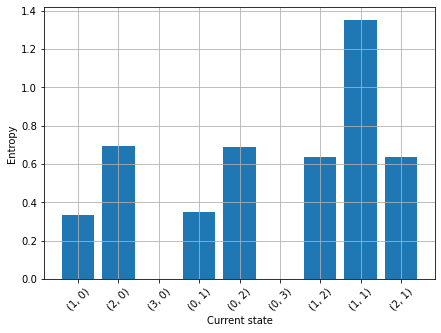

In [14]:
matplotlib.rcParams.update({'font.size': 15}) # font size
plt.figure(figsize=(7, 5))

values = np.arange(1,n_states,1) # numbering the states
plt.bar(values,H_vec)  # producing a bar chart of the entropies

plt.ylabel('Entropy')          # y label
plt.xlabel('Current state')    # x label

states = [(1,0),(2,0),(3,0),(0,1),(0,2),(0,3),(1,2),(1,1),(2,1)]  # state labels
plt.xticks(range(1,n_states), states, rotation=45)   # customizing the x ticks
plt.grid()    # adds grid
plt.savefig('entropy_3mosq.pdf', bbox_inches='tight')   # save figure